# 2D parameter estimation using MCMC

This example will cover:

 - Use MCMC to infer kernel paramaters
 - Finding sample with highest log-prob from the mcmc chain
 - Visualising results of sampling
 - Making predictions


In [2]:
from gpvecchia import cov
from gpvecchia.vecchia import GPtideVecchia
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from gptide import stats as gpstats

from numba import njit

## Generate some data

In [14]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0.5
η = 10
ℓ_x = 5*900
ℓ_y = 5*1800

η_s = 5
ℓ_x_s = 5*100
ℓ_y_s = 5*200

dx = 200.
dy = 400.


@njit(cache=True)
def kernel_2d(x, xpr, params):
    """
    2D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            
    """
    eta, lx, ly = params
    
    # Build the covariance matrix
    C  = cov.matern32_1d(x[1,None], xpr[1,None], [eta, ly]) / eta**2 
    C *= cov.matern32_1d(x[0,None], xpr[0,None], [eta, lx]) / eta**2
    C *= eta**2 
    
    return C


covfunc = kernel_2d

###
# Domain size parameters
N = 50

covparams = (η, ℓ_x, ℓ_y)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]-dx/2
yd = np.arange(0,dy*N,dy)[:,None]-dy/2

# Make a grid
Xg, Yg = np.meshgrid(xd, yd)

# Vectorise grid and stack
Xv = Xg.ravel()
Yv = Yg.ravel()
X = np.hstack([Xv[:,None], Yv[:,None]])

order_func = np.random.permutation
order_params = len(X)

GP_large = GPtideVecchia(X, X.copy(), noise, covfunc, covparams,
                         order_func=order_func, order_params=order_params)

# Use the .prior() method to obtain some samples
zd_large = GP_large.sample_prior(samples=1, add_noise=True)
zg_large = zd_large.reshape(Xg.shape)


## Add in a small-scale field 
covparams_s = (η_s, ℓ_x_s, ℓ_y_s)

GP_small = GPtideVecchia(X, X.copy(), noise, covfunc, covparams_s,
                         order_func=order_func, order_params=order_params)

# Use the .prior() method to obtain some samples
zd_small = GP_small.sample_prior(samples=1, add_noise=True)
zg_small = zd_small.reshape(Xg.shape)

In [15]:
zd_total = zd_large + zd_small

In [16]:
ll = GP_large.log_marg_likelihood(zd_total)
print(f"Log marginal likelihood: {ll:.3f}")

ll_s = GP_small.log_marg_likelihood(zd_total)
print(f"Log marginal likelihood small scale: {ll_s:.3f}")

Log marginal likelihood: -22221.344
Log marginal likelihood small scale: -2981.744


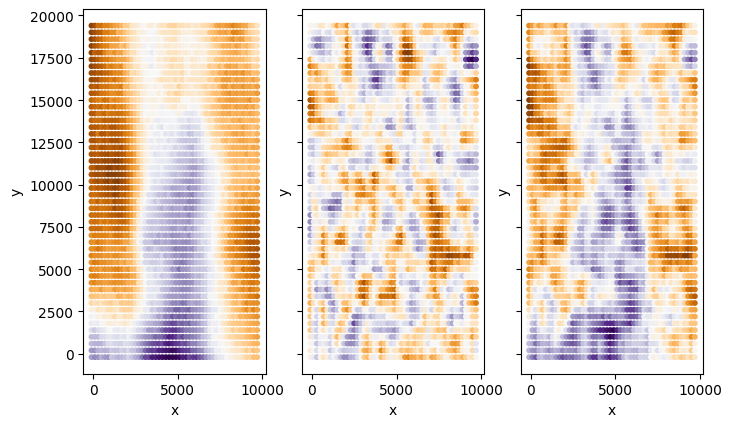

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(8, 12), sharey=True)

for x , d in zip(ax, [zg_large, zg_small, zd_total]):
    x.scatter(Xg, Yg, c=d.ravel(), s=10, cmap='PuOr')
    x.set(ylabel='y', xlabel='x', aspect='equal')

## Sample total field using large scale

In [30]:
GP_filt = GPtideVecchia(X, X.copy(), covparams_s[0], covfunc, covparams,
                         order_func=order_func, order_params=order_params)

z_large_pred, z_large_var = GP_filt(zd_total)


Using training points for prediction


In [43]:
from gptide.gpscipy import GPtideScipy
from gptide import cov as covscipy

def kernel_2d_scipy(x, xpr, params):
    eta, lx, ly = params
    C  = covscipy.matern32(x[:,1,None], xpr.T[:,1,None].T, ly)
    C *= covscipy.matern32(x[:,0,None], xpr.T[:,0,None].T, lx)
    C *= eta**2
    return C

GP_scipy = GPtideScipy(X, X.copy(), noise, kernel_2d_scipy, covparams)
z_large_scipy = GP_scipy(zd_total)
z_large_scipy = z_large_scipy.reshape(Xg.shape)

GP_scipy_n = GPtideScipy(X, X.copy(), covparams_s[0], kernel_2d_scipy, covparams)
z_large_scipy_n = GP_scipy_n(zd_total)
z_large_scipy_n = z_large_scipy_n.reshape(Xg.shape)

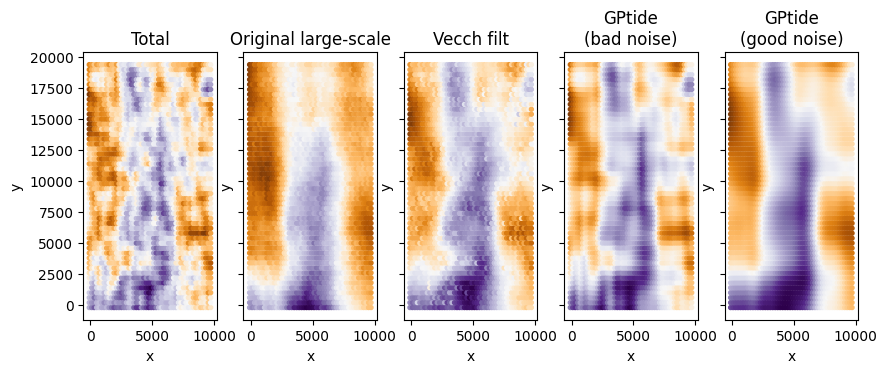

In [45]:
fig, ax = plt.subplots(1, 5, figsize=(10, 20), sharey=True)

ax[0].scatter(Xg, Yg, c=zd_total, s=8, cmap='PuOr')

ax[1].scatter(Xg, Yg, c=zg_large, s=8, cmap='PuOr')

ax[2].scatter(Xg, Yg, c=z_large_pred, s=8, cmap='PuOr')

ax[3].scatter(Xg, Yg, c=z_large_scipy, s=8, cmap='PuOr')

ax[4].scatter(Xg, Yg, c=z_large_scipy_n, s=8, cmap='PuOr')

for x, t in zip(ax, ['Total', 'Original large-scale', 'Vecch filt', 'GPtide\n(bad noise)', 
                    'GPtide\n(good noise)']):
    x.set(ylabel='y', xlabel='x', aspect='equal', title=t)


## Inference

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


In [6]:
from gptide import mcmc
n = len(xd)
covparams

(10, 900, 1800)

In [7]:
# Initial guess of the noise and covariance parameters (these can matter)

noise_prior      = gpstats.truncnorm(0.4, 0.25, 1e-15, 1)           # noise - true value 0.5
covparams_priors = [gpstats.truncnorm(8, 3, 2, 14),                   # eta   - true value 10
                    gpstats.truncnorm(600, 200, 1e-15, 1e4),           # ℓ_x - true value 900
                    gpstats.truncnorm(1400, 250, 1e-15, 1e4)           # ℓ_y - true value 1800
                   ]

samples, log_prob, priors_out, sampler = mcmc.emcee(X, 
                                                 zd, 
                                                 covfunc, 
                                                 covparams_priors,
                                                 noise_prior,
                                                 GPclass=GPtideVecchia,
                                                 gp_kwargs={'order_func':order_func, 'order_params':order_params},                                                 
                                                 nwarmup=50,
                                                 niter=50,
                                                 nwalkers=40)


Running burn-in...


100%|██████████| 50/50 [03:23<00:00,  4.08s/it]


Running production...


100%|██████████| 50/50 [03:33<00:00,  4.28s/it]


An alternate inference could be performed with Metropolis Hasting sampling:

```
samples, lp_samples, accept_samples, attrs = mcmc.mh(
                                                X, 
                                                zd, 
                                                covfunc, 
                                                covparams_priors,
                                                noise_prior,
                                                nwarmup=50,
                                                niter=50)
```

No luck with MH + Vecchia for now...

## Find sample with highest log prob

In [9]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f},  Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('ℓ_x (true):   {:3.2f},  ℓ_x   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
print('ℓ_y (true):   {:3.2f},  ℓ_y   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 


Noise (true): 0.50,  Noise (mcmc): 0.53
η   (true):   10.00,  η     (mcmc): 8.42
ℓ_x (true):   900.00,  ℓ_x   (mcmc): 786.91
ℓ_y (true):   1800.00,  ℓ_y   (mcmc): 1579.47


## Posterior density plot

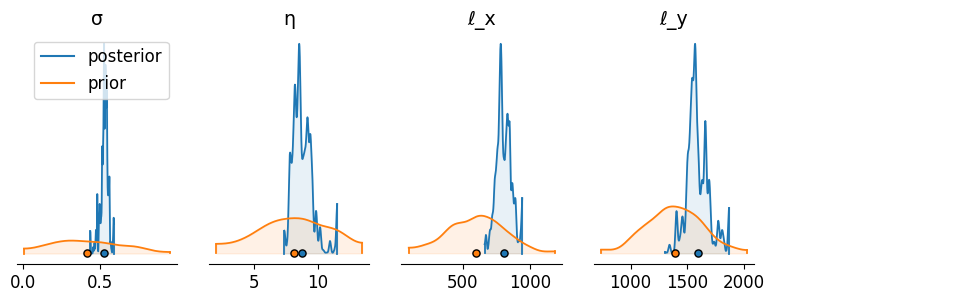

In [10]:
labels = ['σ','η','ℓ_x', 'ℓ_y']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)


## Posterior corner plot

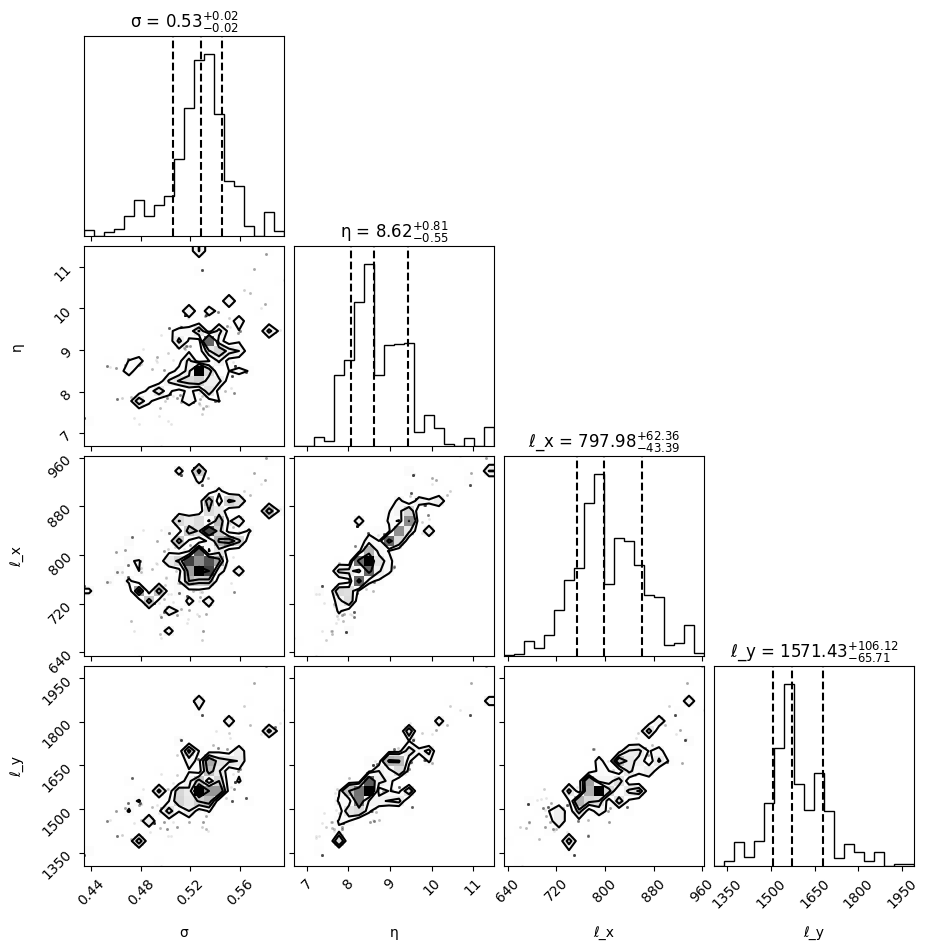

In [11]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

## Condition and make predictions

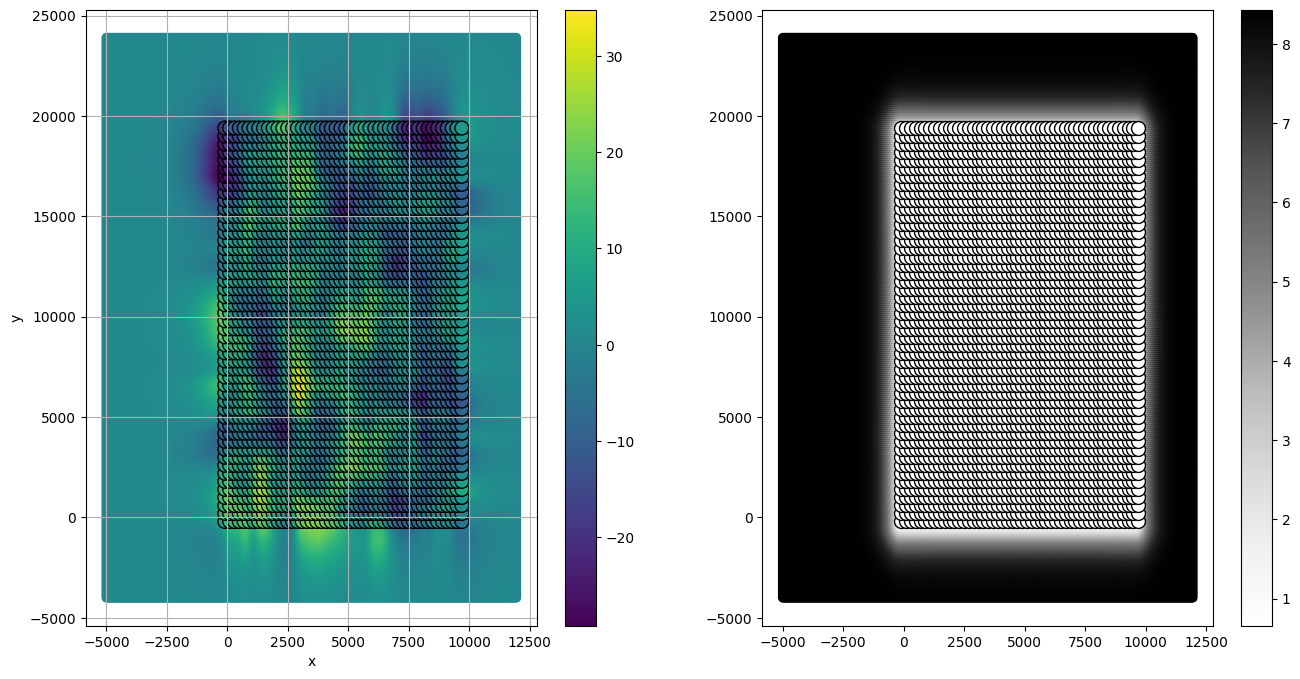

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_ylabel('y')
ax[0].set_xlabel('x')

# xo = np.arange(0,dx*N,dx/3)[:,None]
xdo = np.arange(-dx*0.5*N, dx*1.2*N, dx/4)[:,None]
ydo = np.arange(-dy*0.2*N, dy*1.2*N, dy/4)[:,None]

# Make a grid
Xgo, Ygo = np.meshgrid(xdo, ydo)

# Vectorise grid and stack
Xvo = Xgo.ravel()
Yvo = Ygo.ravel()
Xo = np.hstack([Xvo[:,None], Yvo[:,None]])
    
OI = GPtideVecchia(X, Xo, MAP[0], covfunc, MAP[1:], 
                    order_func=order_func, order_params=order_params)
out_map, map_var = OI(zd)

ax[0].scatter(Xgo, Ygo, c=out_map, alpha=1)
sc = ax[0].scatter(Xg, Yg,   c=zg, s=100, edgecolors='k')

ax[0].grid()
plt.colorbar(sc)

suq = ax[1].scatter(Xgo, Ygo, c=map_var, alpha=1, cmap='Greys')
ax[1].scatter(Xg, Yg, c='w', s=100, edgecolors='k', facecolor='none')
plt.colorbar(suq)